In [1]:
#LogP/SA calculator

In [4]:
import random
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFreeSASA
from rdkit.Chem import rdMolDescriptors
import numpy as np
import time


# import database modules
import pymongo
from pymongo import MongoClient

# multithreading! - please use caution when using this
# the physical server has a Ryzen 7 2700X with 8 cores/16 threads of which the VM that runs CoCalc is allocated 9 threads
# that VM also runs some other stuff, so please try not to use more than 6 threads on an extended basis
import concurrent.futures

# import our libraries
import DBgenerate

In [3]:
# connect to the database
database_IP = "192.168.41.8"
database_port = 27017
client = MongoClient('192.168.41.8',port=27017)

In [10]:
#monomers for polyamides
amide_dict={'Nylon6': 'CCCCCC(=O)N'
}

#monomers and comonomers for polycarbonates
carbonate_dict={'BPA_Carbonate':  'c1ccc(cc1)C(C)(C)c1ccc(cc1)OC(=O)O'
}

#monomers and comonomers for polyesters
ester_dict={'Butylene_Adip': 'C(=O)CCCCC(=O)OCCCCO',
          'Butylene_Succinate': 'C(=O)CCC(=O)OCCCCO', 
          'Butylene_Terephthalate': 'CCCCOC(=O)c1ccc(cc1)C(=O)O',
          'Ethylene_Terephthalate': 'CCOC(=O)c1ccc(cc1)C(=O)O', 
          '3HBV': 'C(CC)CC(=O)O', 
          '3HB': 'C(C)CC(=O)O',
          'Lactic_acid': 'C(C)C(=O)O',
}

#monomers for polyethers
ether_dict={'Ethylene_oxide': 'CCO',
            'Propylene_oxide': 'CC(C)O'
}

#Vinyl monomers written to depict primary addition of alkene (i.e. substituent is on second carbon of alkene)
vinyl_dict={'Acrylonitrile': 'CC(C#N)',
          'Dimethylacrylamide': 'CC(C(=O)N(C)(C))',
          'Ethylene': 'CC',
          'Hydroxyethylmethacrylate': 'CC(C(=O)OCCO)(C)',
          'Methylacrylate': 'CC(C(=O)OC)C',
          'Methylmethacrylate': 'CC(C(=O)OC)(C)',
          'Propylene': 'CC(C)',
          'Styrene': 'CC(c1ccccc1)',
          'Vinylalcohol': 'CC(O)',
          'Vinylacetate': 'CC(OC(=O)C)'
}

#initiator dictionary (i.e. endgroup of polymer chain)
init_dict={'Benzyl': 'c1ccccc1CO', 
           'Butyl': 'CCCC',
           'Hydroxyl': 'O', 
           'Hydrogen': '',
           'Methoxy': 'CO', 
           'Methyl': 'C', 
           'Vinyl': 'C=C'}

In [11]:
#Section 1
#constructing SMILES string for polymers with one type of vinyl monomer unit

#enter number of monomers
n=5

#choose type of initiating group
init=init_dict['Methoxy']  

#choose monomer composition
comp = 'Acrylonitrile'
N1=vinyl_dict[comp]

def Polymer1(n):
    n_mer = init+(N1*n)
    return n_mer
Polymer1(n)

'COCC(C#N)CC(C#N)CC(C#N)CC(C#N)CC(C#N)'

In [5]:
#construct SMIlES string for alternating copolymer
#currently not used to generate SMILES strings

##enter number of monomers
x=5
# y=5

#choose type of initiating group
initiator=init_dict['Hydrogen']  

#choose monomer composition
X1=vinyl_dict['Ethylene']
Y1=vinyl_dict['Propylene']

def Alt_copolymer(x):
    alt_copol=(X1+Y1)*x
    return alt_copol
Alt_copolymer(x)

'CCCC(C)CCCC(C)CCCC(C)CCCC(C)CCCC(C)'

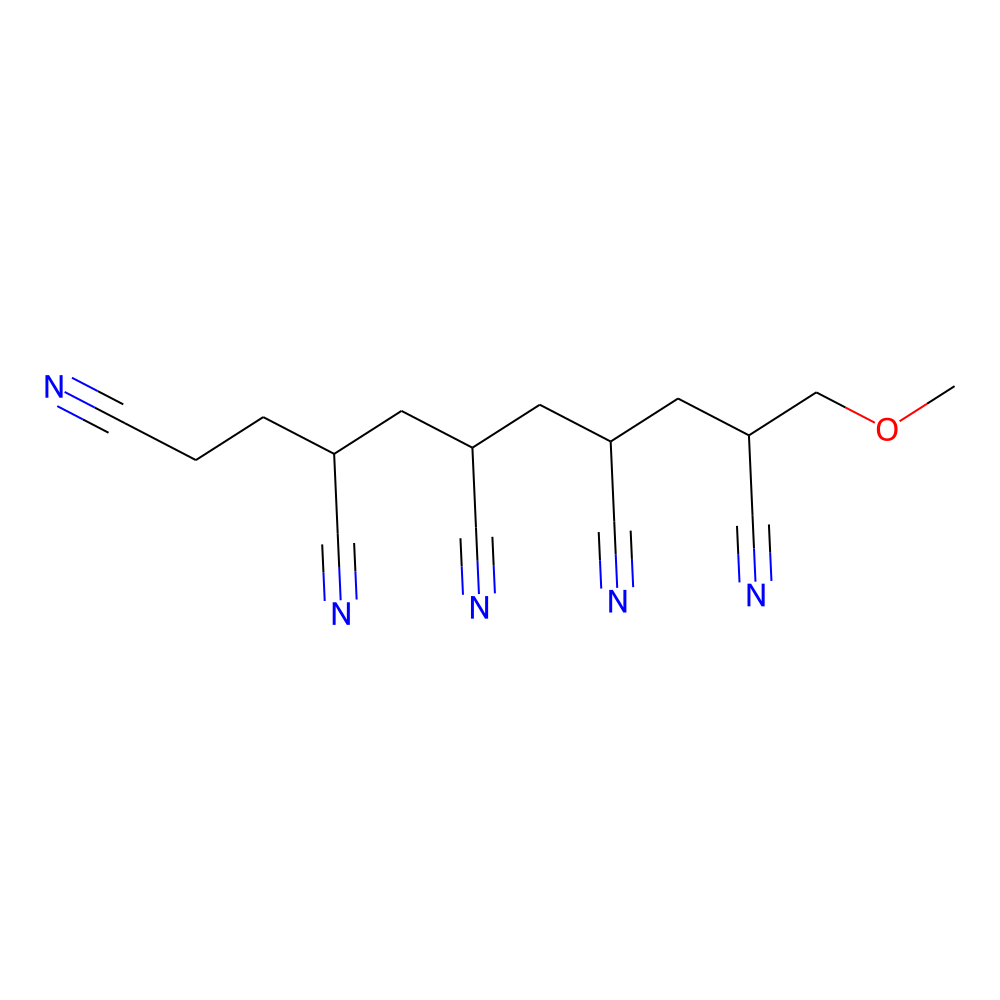

In [12]:
#method to draw molecules

mer_n = [Polymer1(n)]
mol = [Chem.MolFromSmiles(mer_n) for mer_n in mer_n]
Draw.MolsToGridImage(mol, molsPerRow=1, subImgSize=(1000, 1000))

In [8]:
#Section 2
#Workflow involves calculating LogP values and SASA for SMILES strings
#Let's check if H's are added before energy minimization with MMFF (or UFF)

In [9]:
# Get the ID of the best conformer given a molecule with conformers and a set of conformer IDs
# Note that mol_h MUST be pre-populated with the desired conformers
def GetBestConformerID(mol_h, ids, returnMinusOne=False):
    best = []
    for id in ids:
        prop = AllChem.MMFFGetMoleculeProperties(mol_h)
        ff = AllChem.MMFFGetMoleculeForceField(mol_h, prop, confId=id)
        ff.Minimize()
        en = float(ff.CalcEnergy())
        econf = (en, id)
        best.append(econf)
    best.sort()
    print("Found "+str(len(best))+" conformations.")
    if len(best) == 0 and returnMinusOne is True:
        return -1
    elif len(best) == 0:
        raise Exception("Error: No valid conformations found for the molecule. Try increasing the number of conformations.")
    # The best conformer is the first tuple and the ID of that conformer is the second value in the tuple
    best_id = int(best[0][1])
    # Return the best ID
    return best_id

# Utility method to save a conformer to a file
# Accepts a molecule, conformer ID, and filename
# Note that this function has a HARDCODED PREFIX FOLDER that it saves files inside of.
def SaveConformationToFile(molecule, confId=-1, filename="scratch"):
    # Hardcoded prefix where the files are saved - change if necessary
    prefix = "molecules/"
    if confId == -1:
        raise Exception("You must provide a conformation ID to use this function.")
    # Get the conformation with the given ID
    best_conf = Chem.MolToMolBlock(molecule,confId=confId)
    # Open the file, write, then close the file.
    f = open(prefix + filename, 'w+')
    # MAKE SURE this doesn't just append to the file over and over again, which would be bad
    f.write(best_conf)
    f.close()
    print("Successfully wrote conformation to file.")
    return prefix + filename

# Given a SMILES string and other parameters, this function generates the required number of conformers and gets the LogP 
# and SASA for the best one
# Calculates logP for the OVERALL MOLECULE since I couldn't work out how to do it for a conformer
# DANGER - the output of this function is NOT 100% consistent; if you get your LogP and SASA from two different runs
# you WILL run into problems. Get ALL your values at the SAME TIME.
def GetLogPAndSASAForBestConformer(smiles, numThreads=1, numConfs=1000, randomSeed=1, filename=None, useRandomCoords=True,
                                  returnMinusOne=False):
    # File prefix - change if necessary
    prefix = "molecules/",
    # First process the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    mol_h = Chem.AddHs(mol)
    # Now generate the conformations
    ids = AllChem.EmbedMultipleConfs(mol_h, numConfs=numConfs, randomSeed=randomSeed, useExpTorsionAnglePrefs=True,
                                     numThreads=numThreads)
    # Find the best one
    try:
        best_conf_id = GetBestConformerID(mol_h, ids)
    except Exception as e:
        if returnMinusOne is True:
            return 0, 1
        else:
            raise e
    print("Best conformer ID is "+str(best_conf_id)+".")
    if filename is not None and returnMinusOne is False:
        # If filename given, save conformation to that file
        SaveConformationToFile(mol_h, confId=best_conf_id, filename=filename)
    elif best_conf_id == -1 and returnMinusOne is True:
        return 0, 1
    # Now calculate LogP and SASA
    # Calculate SASA based on the best conformer
    # classifyAtoms CRASHED when I tried it with , confIdx=best_conf_id
    # but someone needs to go back and make sure it's actually OK to use it without
    # and that that won't cause problems!
    radii = rdFreeSASA.classifyAtoms(mol_h)
    sasa = rdFreeSASA.CalcSASA(mol_h, radii, confIdx=best_conf_id)
    # LogP does NOT have an option to feed in a conformer so just calculate it for the overall molecule
    logP = Descriptors.MolLogP(mol_h)
    # Now return LogP and SASA
    return logP, sasa

In [13]:
file_name=comp+"_"+str(n)+"mer"+str(numConfs)+"_conf"+".mol" #name of mol file
print(file_name)

NameError: name 'numConfs' is not defined

In [11]:
#save 3D molecule as .mol file
mol = Chem.MolFromSmiles(Polymer1(n)) #convert SMILES string to molecule
mol_h = Chem.AddHs(mol) #add hydrogens
AllChem.EmbedMolecule(mol_h,randomSeed=0xf00d)   # optional random seed for reproducibility
AllChem.MMFFOptimizeMolecule(mol_h) #performed MMFF
#print(Chem.MolToMolBlock(mol_h))
#print(Chem.MolToMolBlock(mol_h),file=open("molecules/"+file_name,'w+')) #open and write to the file

#GetBestConformationAndSave(Polymer1(n),numConfs=10,numThreads=5)

1

In [12]:
ids = AllChem.EmbedMultipleConfs(mol_h, numConfs=10, randomSeed=1, useExpTorsionAnglePrefs=True, numThreads=6)
best=[]
for id in ids:
	prop = AllChem.MMFFGetMoleculeProperties(mol_h)
	ff = AllChem.MMFFGetMoleculeForceField(mol_h, prop, confId=id)
	ff.Minimize()
	en = float(ff.CalcEnergy())
	econf = (en, id)
	best.append(econf)
best.sort()
print(best[0])
print(best)


(137.62716142753905, 8)
[(137.62716142753905, 8), (137.69443938028058, 5), (140.76064990691162, 7), (145.04642318719368, 2), (145.39659823577784, 4), (145.62997807656248, 1), (146.22944438800985, 6), (148.750927280742, 9), (152.95199978943523, 3), (165.17161833597677, 0)]


In [13]:
#LogP values for n-mer

z=Chem.MolFromSmiles(Polymer1(n))
print('LogP with hydrogens is: '+ str(Descriptors.MolLogP(z, includeHs=True)))

z_no_Hs=Chem.MolFromSmiles(Polymer1(n))
print('LogP without hydrogens is: '+ str(Descriptors.MolLogP(z_no_Hs, includeHs=False)))

LogP with hydrogens is: 10.571099999999994
LogP without hydrogens is: 5.159100000000002


In [14]:
LogP_SASA = np.divide(LogP_Polymer1,SASA_Polymer1)
print("LogP/SA:", LogP_SASA.round(4))

NameError: name 'np' is not defined

In [20]:
# Begin database update block

# Iterate across the monomer dictionary

# function to generate all conformers

# Update the DB - creates a new connection so it should be thread safe

initiators = {'Hydrogen':''}
test_monomers = vinyl_dict




#here is the rest of polymers from the monomer dictionaries
initiators=init_dict
#these monomers are organized according to functional groups as described in cell 4
test_monomers.update(amide_dict)
test_monomers.update(carbonate_dict)
test_monomers.update(ester_dict)
test_monomers.update(ether_dict)

# Here we go...

#DBgenerate.SaveLogPAndSASAForAllConformersToDB(initiators=initiators,monomers=test_monomers,start=1,stop=12,step=1,precision=100,
#                                    numThreads=4,updateDB=True,version=2)


Generated 84 polymers
[{'smiles': 'CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 1, 'randomSeed': 1}, {'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 2, 'randomSeed': 1}, {'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 3, 'randomSeed': 1}, {'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 4, 'randomSeed': 1}, {'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)C

Found 100 conformations.
Best conformer ID is 9.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 1, 'randomSeed': 1, 'sasa': 231.7865364721515, 'LogP': 1.7397, 'bestConformerID': 9, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 23 22  0  0  0  0  0  0  0  0999 V2000\n    2.8986    1.9673    3.4385 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8580    2.1366    2.3456 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2691    0.8151    1.9139 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5718   -0.2801    2.3646 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3420    1.0320    0.9378 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2903   -0.1586    0.4510 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.3145    0.2200   -0.6155 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4512    1.0738   -0.0488 C   0

Found 100 conformations.
Best conformer ID is 87.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 419.77729449811346, 'LogP': 3.0893000000000015, 'bestConformerID': 87, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 44 43  0  0  0  0  0  0  0  0999 V2000\n   -1.1401   -2.4405    2.8875 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6596   -1.4124    1.8641 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.7550   -0.3922    1.5957 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6931   -0.1516    2.3422 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5276    0.2255    0.4018 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4995    1.2197    0.0528 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0406    1.9353   -1.2147 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7

Found 100 conformations.
Best conformer ID is 44.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 985.2496414111112, 'LogP': 7.1381000000000085, 'bestConformerID': 44, 'bestConformerMolBlock': '\n     RDKit          3D\n\n107106  0  0  0  0  0  0  0  0999 V2000\n    1.1595    3.9941   -5.1183 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3262    2.6992   -4.3209 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1589    2.9758   -3.0793 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1205    4.0091   -2.4248 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.9201    1.8854   -2.7786 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.6994    2.0173   -1.5819 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.3981    0.6868   -1.3271 C   0 

Found 100 conformations.
Best conformer ID is 38.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 615.9442963256025, 'LogP': 4.438900000000004, 'bestConformerID': 38, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 65 64  0  0  0  0  0  0  0  0999 V2000\n   -1.0492   -3.6859   -2.5490 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7932   -2.4272   -1.7181 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1031   -1.7031   -1.4679 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2903   -0.5292   -1.7620 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.0035   -2.5090   -0.8474 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2250   -1.8590   -0.4756 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.0786   -2.8326    0.3323 C   0  0  0  0  0  0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 85.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 805.8226721090474, 'LogP': 5.788500000000006, 'bestConformerID': 85, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 86 85  0  0  0  0  0  0  0  0999 V2000\n   -3.5899    2.6875   -3.0307 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4733    1.9475   -2.2946 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1738    2.6642   -0.9894 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.0133    3.1748   -0.2633 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8369    2.6192   -0.7337 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4415    3.2345    0.5022 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0594    3.0226    0.6677 C   0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 44.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 985.2496414111112, 'LogP': 7.1381000000000085, 'bestConformerID': 44, 'bestConformerMolBlock': '\n     RDKit          3D\n\n107106  0  0  0  0  0  0  0  0999 V2000\n    1.1595    3.9941   -5.1183 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3262    2.6992   -4.3209 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1589    2.9758   -3.0793 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1205    4.0091   -2.4248 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.9201    1.8854   -2.7786 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.6994    2.0173   -1.5819 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.3981    0.6868   -1.3271 C   0 

Found 100 conformations.
Best conformer ID is 44.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 1174.1534392355857, 'LogP': 8.487700000000007, 'bestConformerID': 44, 'bestConformerMolBlock': '\n     RDKit          3D\n\n128127  0  0  0  0  0  0  0  0999 V2000\n    2.8464    4.5947    1.4855 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0386    3.6664    0.5803 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0061    4.2359   -0.8280 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0301    5.4291   -1.0987 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9240    3.2253   -1.7388 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8384    3.6731   -3.0963 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8784    2.4672   

Found 100 conformations.
Best conformer ID is 15.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 1362.2916895363503, 'LogP': 9.8373, 'bestConformerID': 15, 'bestConformerMolBlock': '\n     RDKit          3D\n\n149148  0  0  0  0  0  0  0  0999 V2000\n    1.5676    1.5537   -2.2914 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.7561    1.8170   -1.3667 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5630    3.1693   -0.6845 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.6459    3.9459   -0.9158 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.5844    3.4157    0.1848 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.5114    4.6667    0.8878 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6120    4.5300

Found 100 conformations.
Best conformer ID is 96.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 1550.5303911210685, 'LogP': 11.186899999999993, 'bestConformerID': 96, 'bestConformerMolBlock': '\n     RDKit          3D\n\n170169  0  0  0  0  0  0  0  0999 V2000\n    0.5066   -1.4241   -4.8262 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9913   -1.6620   -5.0912 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1926   -3.0856   -5.5848 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5490   -3.3718   -6.7202 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9077   -3.9883   -4.6058 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0749   -5.3570   -4.9921 C   0  0  0  0  0  0  0  0  0  0  

Found 100 conformations.
Best conformer ID is 84.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 1728.5221934027554, 'LogP': 12.536499999999986, 'bestConformerID': 84, 'bestConformerMolBlock': '\n     RDKit          3D\n\n191190  0  0  0  0  0  0  0  0999 V2000\n   -0.7317   -5.3780   -3.3281 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7171   -3.8780   -3.6190 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4046   -3.5521   -4.5893 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4592   -4.1659   -4.6693 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0757   -2.4501   -5.3214 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0764   -1.9930   -6.2452 C   0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 53.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 1921.4646389779875, 'LogP': 13.886099999999978, 'bestConformerID': 53, 'bestConformerMolBlock': '\n     RDKit          3D\n\n212211  0  0  0  0  0  0  0  0999 V2000\n   -6.6516   -5.9297   -3.5072 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.2652   -5.0595   -2.3095 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.4016   -4.0958   -1.9989 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -8.3262   -3.8332   -2.7584 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.2418   -3.5683   -0.7536 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -8.2775   -2.6624   -0.3537 C   0

Found 100 conformations.
Best conformer ID is 70.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 2116.8235773606184, 'LogP': 15.23569999999997, 'bestConformerID': 70, 'bestConformerMolBlock': '\n     RDKit          3D\n\n233232  0  0  0  0  0  0  0  0999 V2000\n   -5.3841    1.9674   -4.9537 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.8520    1.0472   -3.8533 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.6833    1.2809   -2.6004 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.8460    0.8970   -2.4978 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.0270    2.0150   -1.6649 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.7450    2.2872   

Found 100 conformations.
Best conformer ID is 70.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)CC(C(=O)OCCCC)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OCCCC)', 'repeatUnitName': 'Butylacrylate', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 2277.9819849871615, 'LogP': 16.58529999999997, 'bestConformerID': 70, 'bestConformerMolBlock': '\n     RDKit          3D\n\n254253  0  0  0  0  0  0  0  0999 V2000\n    2.3300   -4.3719    2.0596 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2894   -3.7084    1.1650 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0295   -4.5579    1.1847 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1075   -5.6006    0.5584 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9151   -4.0108    1.9998 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.103

Found 100 conformations.
Best conformer ID is 85.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 1, 'randomSeed': 1, 'sasa': 177.2461340440785, 'LogP': 0.48460000000000003, 'bestConformerID': 85, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 18 17  0  0  0  0  0  0  0  0999 V2000\n   -1.2806   -0.8468    1.6632 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4933   -0.6104    0.1764 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1991   -0.2766   -0.5515 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8719   -0.2082    0.0524 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2938   -0.0477   -1.9229 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4794   -0.3318   -2.7169 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9373    0.1579   -2.6688 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5917  

Found 100 conformations.
Best conformer ID is 73.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 315.164726261749, 'LogP': 0.5791, 'bestConformerID': 73, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 34 33  0  0  0  0  0  0  0  0999 V2000\n   -1.2101   -2.9762    0.4857 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6277   -1.5990    0.1537 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8229   -1.7757   -0.3128 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7600   -1.5414    0.4550 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0418   -2.2476   -1.6075 N   0  0  0  0  0  0  0  0  0  0  0  0\n    2.4213   -2.3445   -2.0572 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0392   -2.1982   -2.6623 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7318

Found 100 conformations.
Best conformer ID is 91.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 451.07675641441085, 'LogP': 0.6736000000000009, 'bestConformerID': 91, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 50 49  0  0  0  0  0  0  0  0999 V2000\n   -0.2235    3.7237   -2.0405 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1442    2.4466   -1.1998 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3152    2.2435   -0.7727 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0583    1.5081   -1.4285 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7866    2.9691    0.3215 N   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9071    3.5693    1.3138 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1351    2.6749    0.7775 C   0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 65.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 585.2659457619801, 'LogP': 0.7681000000000024, 'bestConformerID': 65, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 66 65  0  0  0  0  0  0  0  0999 V2000\n    0.8624   -3.8507    0.2289 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4562   -2.4854    0.5922 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3550   -2.2797    2.1113 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5106   -1.5107    2.5811 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.2139   -2.9991    2.9359 N   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0913   -2.8373    4.3769 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3643   -3.7769    2.4943 C   0

Found 100 conformations.
Best conformer ID is 64.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 721.1687711703312, 'LogP': 0.8626000000000049, 'bestConformerID': 64, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 82 81  0  0  0  0  0  0  0  0999 V2000\n   -4.3703    3.8881   -0.7669 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.0585    3.1628   -0.4566 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6725    3.4544    0.9985 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.9509    2.6473    1.8905 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0453    4.6677    1.2803 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5817    4.8691    2.6438 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.3876    5.4824

Found 100 conformations.
Best conformer ID is 22.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 861.2649620273179, 'LogP': 0.9571000000000074, 'bestConformerID': 22, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 98 97  0  0  0  0  0  0  0  0999 V2000\n   -7.0707    0.6537    0.8956 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.5593    0.4243    0.9632 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.3195   -1.0698    1.2008 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.4075   -1.5348    2.3411 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.0733   -1.8761    0.0943 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.7806   -3.2828    0.3272 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -

Found 100 conformations.
Best conformer ID is 45.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 973.7519848414836, 'LogP': 1.05160000000001, 'bestConformerID': 45, 'bestConformerMolBlock': '\n     RDKit          3D\n\n114113  0  0  0  0  0  0  0  0999 V2000\n    3.3010   -2.3565    3.4341 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9396   -1.7482    3.7923 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8612   -1.5548    5.3143 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9475   -0.4266    5.8057 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7260   -2.6813    6.1190 N   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3788   -4.0180    5.6543 C   0  0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 96.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 1114.8715046649359, 'LogP': 1.1461000000000126, 'bestConformerID': 96, 'bestConformerMolBlock': '\n     RDKit          3D\n\n130129  0  0  0  0  0  0  0  0999 V2000\n    4.5173    4.8740   -3.7534 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3577    5.0935   -2.7734 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.8121    6.5228   -2.9142 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.5010    7.3937   -3.4539 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5602    6.8104   -2.3764 N   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0993    8.1928   -2.3805 C   0  0  0

Found 100 conformations.
Best conformer ID is 13.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 1253.8463972086245, 'LogP': 1.2406000000000088, 'bestConformerID': 13, 'bestConformerMolBlock': '\n     RDKit          3D\n\n146145  0  0  0  0  0  0  0  0999 V2000\n    0.9492   -5.4029   -5.0879 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9950   -3.9316   -4.6481 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8512   -3.8216   -3.3761 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8789   -4.7514   -2.5662 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5103   -2.6207   -3.1182 N   0  0  0  0  0  0  0  0  0  0  0  0\n    3.0582   -1.7831   -4.

Found 100 conformations.
Best conformer ID is 3.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 1364.5374423223045, 'LogP': 1.3351000000000033, 'bestConformerID': 3, 'bestConformerMolBlock': '\n     RDKit          3D\n\n162161  0  0  0  0  0  0  0  0999 V2000\n    0.9087   -0.9702    6.9834 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1273   -0.4140    5.7843 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9736    0.5320    6.2891 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4247    0.3979    7.4315 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4660    1.5066    5.4299 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.5707 

Found 100 conformations.
Best conformer ID is 1.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 1498.5714144970668, 'LogP': 1.4295999999999989, 'bestConformerID': 1, 'bestConformerMolBlock': '\n     RDKit          3D\n\n178177  0  0  0  0  0  0  0  0999 V2000\n   -2.9223   -1.9041   -9.1670 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.3482   -0.5749   -8.6634 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.1010    0.5848   -9.3317 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.5988    1.1979  -10.2761 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.3769    0.8933   -8.8563 N   0  0  0  0  0  0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 42.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))CC(C(=O)N(C)(C))', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)N(C)(C))', 'repeatUnitName': 'Dimethylacrylamide', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 1645.988477351836, 'LogP': 1.5240999999999942, 'bestConformerID': 42, 'bestConformerMolBlock': '\n     RDKit          3D\n\n194193  0  0  0  0  0  0  0  0999 V2000\n    8.3087    1.9309   -4.4685 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.8029    1.7568   -4.7002 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.4023    2.3617   -6.0525 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.1243    3.2083   -6.5864 O   0  0  0  0  0  0  0  0  0  0  0  0\n    5.1989    1.9669   -6.6249 N   0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 55.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 140.6540320995907, 'LogP': 1.8064, 'bestConformerID': 55, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 14 13  0  0  0  0  0  0  0  0999 V2000\n   -1.7283    2.2483   -0.4471 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4550    1.5464   -0.8913 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7451    0.1442   -1.4228 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5282   -0.5577   -1.8670 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2251    1.6905    0.3532 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4975    3.2497   -0.0705 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4302    2.3523   -1.2807 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2377    1.4876   -0.0436 H   0  0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 50.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 191.87039889538465, 'LogP': 2.5866000000000007, 'bestConformerID': 50, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 20 19  0  0  0  0  0  0  0  0999 V2000\n   -0.8545   -1.7698   -1.4434 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.9949   -0.7690   -1.3382 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5430    0.6301   -0.9143 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9818    0.6810    0.5085 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6455    2.1152    0.9197 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.0843    2.1729    2.3316 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.0704   -1.4035   -2.1135 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.2246   -2.7197   -1.8426 H   0  0  0  0 

Found 100 conformations.
Best conformer ID is 96.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 242.95654175141112, 'LogP': 3.3668000000000022, 'bestConformerID': 96, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 26 25  0  0  0  0  0  0  0  0999 V2000\n   -0.7447   -3.0654    2.0684 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3849   -2.4707    1.2425 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1002   -1.0161    0.8695 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2389   -0.4217    0.0389 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9538    1.0348   -0.3351 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0960    1.6277   -1.1631 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8149    3.0497   -1.6533 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7140    4.0705   -0.5305 C   0  0  0  

Found 100 conformations.
Best conformer ID is 1.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 293.2461497413592, 'LogP': 4.147000000000004, 'bestConformerID': 1, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 32 31  0  0  0  0  0  0  0  0999 V2000\n    1.2318   -1.8093   -5.1075 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.2370   -0.6708   -5.0333 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.6086    0.6784   -4.6758 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8794    0.7348   -3.3290 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7862    0.4200   -2.1368 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.1191    0.6818   -0.7827 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.0668   -0.2438   -0.5017 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6233   -0.0190    0.9061 C   0  0  0  0 

Found 100 conformations.
Best conformer ID is 81.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 344.2101468757017, 'LogP': 4.9272000000000045, 'bestConformerID': 81, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 38 37  0  0  0  0  0  0  0  0999 V2000\n   -3.5514    4.2522   -0.2676 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.0939    2.9986   -0.9363 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2315    1.7572   -0.6987 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.8451    1.8502   -1.3400 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0647    0.5444   -1.1645 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3245    0.6401   -1.7992 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.1067   -0.6758   -1.7540 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4706   -1.1194   -0.3344 C   0  0  

Found 100 conformations.
Best conformer ID is 66.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 395.78187795683397, 'LogP': 5.707400000000006, 'bestConformerID': 66, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 44 43  0  0  0  0  0  0  0  0999 V2000\n    0.7064   -2.5473    6.0419 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6571   -3.3524    4.7531 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2255   -2.6758    3.7033 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2666   -3.4883    2.4077 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.2302   -2.9209    1.3609 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9557   -1.4844    0.9020 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4200   -1.3044    0.2556 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6900    0.1307   -0.2089 C   0  0

Found 100 conformations.
Best conformer ID is 1.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 439.3093339778862, 'LogP': 6.487600000000007, 'bestConformerID': 1, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 50 49  0  0  0  0  0  0  0  0999 V2000\n    0.0295    1.7947   -5.0017 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8569    2.7847   -4.2614 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.9701    2.1167   -3.4514 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4508    1.3199   -2.2512 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6065    0.7118   -1.4514 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1607    0.0155   -0.1619 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.2448   -1.1867   -0.4041 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9447   -1.9292    0.9006 C   0  0 

Found 100 conformations.
Best conformer ID is 28.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 494.4627039850987, 'LogP': 7.267800000000007, 'bestConformerID': 28, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 56 55  0  0  0  0  0  0  0  0999 V2000\n   -2.8486   -4.2703   -0.1438 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.1193   -2.9996   -0.9351 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.8526   -2.4937   -1.6262 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0938   -1.2787   -2.5267 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.5306   -0.0292   -1.7574 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6124    1.1878   -2.6826 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.1402    2.4499   -1.9920 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.3595    2.9146   -0.7586 C   0

Found 100 conformations.
Best conformer ID is 16.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 545.0872233648724, 'LogP': 8.048000000000007, 'bestConformerID': 16, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 62 61  0  0  0  0  0  0  0  0999 V2000\n   -0.2234    6.8836    0.6189 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5968    7.0280   -0.6533 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0904    6.7603   -0.4525 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.4524    5.3667    0.0704 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0043    4.2339   -0.8551 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.4912    2.8759   -0.3443 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0388    1.7410   -1.2646 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5232    0.3832   -0.7534 C 

Found 100 conformations.
Best conformer ID is 65.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 599.6024040569861, 'LogP': 8.828200000000002, 'bestConformerID': 65, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 68 67  0  0  0  0  0  0  0  0999 V2000\n    3.5003    0.7794   -6.6540 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1228    0.2222   -5.2910 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.2945    0.2926   -4.3113 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.8989   -0.2508   -2.9370 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.0663   -0.3141   -1.9480 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.7392    1.0235   -1.6247 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.8158    2.1238   -1.0942 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.0903    1.7403    0.1971 

Found 100 conformations.
Best conformer ID is 89.
Found at least one conformer
Now adding to DB
{'smiles': 'CCCCCCCCCCCCCCCCCCCCCCCC', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC', 'repeatUnitName': 'Ethylene', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 653.6498800979298, 'LogP': 9.608399999999998, 'bestConformerID': 89, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 74 73  0  0  0  0  0  0  0  0999 V2000\n    7.5299    5.1261   -5.9883 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.3022    4.3934   -5.4681 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.0401    4.8168   -6.2208 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.7950    4.0208   -5.8191 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3574    4.2619   -4.3716 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0510    3.5263   -4.0615 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4985    3.8197   -2.6623 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.3900    3.2919   -1.535

Found 100 conformations.
Best conformer ID is 13.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 1, 'randomSeed': 1, 'sasa': 177.38847536972088, 'LogP': 0.8154, 'bestConformerID': 13, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 17 16  0  0  0  0  0  0  0  0999 V2000\n   -0.8796   -2.4708   -1.5224 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5525   -1.1071   -0.9197 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0931    0.0103   -1.7932 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.9907   -0.1089   -2.6157 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4353    1.1734   -1.5187 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8829    2.2890   -2.2896 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.1225   -0.9818    0.4881 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4383   -3.2757   -0.9255 H   0

Found 100 conformations.
Best conformer ID is 57.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 317.92691093157606, 'LogP': 1.3848, 'bestConformerID': 57, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 32 31  0  0  0  0  0  0  0  0999 V2000\n   -2.7569   -0.9694   -0.3890 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.3354   -0.7550   -0.9025 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4146   -0.1369   -2.2877 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4045    1.0639   -2.5220 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5200   -1.1166   -3.2297 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.6140   -0.6277   -4.5680 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5330    0.1293    0.0672 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9585    0.1948   -

Found 100 conformations.
Best conformer ID is 61.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 456.03836460145055, 'LogP': 1.9541999999999997, 'bestConformerID': 61, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 47 46  0  0  0  0  0  0  0  0999 V2000\n   -4.5197    2.0481   -2.8630 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.6488    1.1777   -1.9610 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.9616   -0.2791   -2.2563 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.4279   -0.9457   -3.1318 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.9379   -0.7262   -1.4171 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.3046   -2.0901   -1.6286 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1574    1.4841   -2.1763 C   0  0  0  0  0  0  0  0  0  0  0  0\n

Found 100 conformations.
Best conformer ID is 3.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 594.8803947956764, 'LogP': 2.5236, 'bestConformerID': 3, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 62 61  0  0  0  0  0  0  0  0999 V2000\n   -4.2882   -0.5094    3.2217 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.4144   -1.0923    2.1148 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2945   -1.4041    0.9194 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.0369   -2.3717    0.8325 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.1448   -0.4426   -0.0337 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.9404   -0.6532   -1.2004 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6671   -2.3418    2.6020 C   0  0  0  0  0  0  0  0  0  0  0  0\n   

Found 100 conformations.
Best conformer ID is 89.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 723.1451477846382, 'LogP': 3.093000000000001, 'bestConformerID': 89, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 77 76  0  0  0  0  0  0  0  0999 V2000\n    3.1380   -0.2705   -2.2131 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.2761   -1.1298   -1.2872 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.0473   -1.3318    0.0091 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.0615   -0.5148    0.9230 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.7751   -2.4807   -0.0071 O   0  0  0  0  0  0  0  0  0  0  0  0\n    4.5448   -2.7048    1.1742 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.8576   -2.4288   -2.0035 C   0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 18.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 855.2952008038262, 'LogP': 3.6624000000000025, 'bestConformerID': 18, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 92 91  0  0  0  0  0  0  0  0999 V2000\n   -0.9869   -2.4159    0.8581 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0933   -2.9864   -0.0281 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4789   -3.6202   -1.2688 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5691   -3.1788   -2.4066 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8451   -4.7789   -0.9255 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2104   -5.4435   -2.0156 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.1193   -1.9063   -0.4190 C   0

Found 100 conformations.
Best conformer ID is 97.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 997.0953792959049, 'LogP': 4.231800000000005, 'bestConformerID': 97, 'bestConformerMolBlock': '\n     RDKit          3D\n\n107106  0  0  0  0  0  0  0  0999 V2000\n   -5.4288    0.0422   -4.1098 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.0908   -0.5048   -4.6115 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.9871    0.4185   -4.1279 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.3530    1.1575   -4.8723 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.8157    0.3332   -2.7812 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.8034    1.2020   -2.2673 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.9017   -1.9705   -4

Found 100 conformations.
Best conformer ID is 96.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 1140.7548582665584, 'LogP': 4.801200000000006, 'bestConformerID': 96, 'bestConformerMolBlock': '\n     RDKit          3D\n\n122121  0  0  0  0  0  0  0  0999 V2000\n    0.9223    1.1373    7.1446 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2997    0.1178    6.0713 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1789    0.0302    5.0520 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5426   -0.9514    4.9175 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0711    1.1737    4.3224 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9700    1.1435    3.3449 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6525  

Found 100 conformations.
Best conformer ID is 18.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 1272.7215193661864, 'LogP': 5.3706000000000085, 'bestConformerID': 18, 'bestConformerMolBlock': '\n     RDKit          3D\n\n137136  0  0  0  0  0  0  0  0999 V2000\n   -1.1999   -3.1980   -5.3879 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0225   -2.2881   -5.5007 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0060   -2.6204   -4.3936 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1236   -3.0807   -4.5951 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4880   -2.3378   -3.1662 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3781   -2.6008   -2.0855 C   0  0  0  0  0  0  0  0  0  0  0  0\

Found 100 conformations.
Best conformer ID is 62.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 1395.4114455146173, 'LogP': 5.940000000000011, 'bestConformerID': 62, 'bestConformerMolBlock': '\n     RDKit          3D\n\n152151  0  0  0  0  0  0  0  0999 V2000\n   -6.9340    0.6954    0.0121 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.4129    0.8462   -0.0444 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.8575    1.5697    1.1789 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.9671    2.4093    1.1486 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.4325    1.0980    2.3213 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.9332    1.6950    3.5183 C   0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 37.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 1529.543257044287, 'LogP': 6.509400000000013, 'bestConformerID': 37, 'bestConformerMolBlock': '\n     RDKit          3D\n\n167166  0  0  0  0  0  0  0  0999 V2000\n   -7.0970   -0.6217   -5.8858 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.3652   -1.9441   -5.6694 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.8065   -2.4517   -6.9866 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.1359   -3.5121   -7.5019 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.8982   -1.5798   -7.5071 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.3400   -1.9996   -8.7530 C   0  0  0  0  

Found 100 conformations.
Best conformer ID is 73.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)CCC(C(=O)OC)C', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)C', 'repeatUnitName': 'Methylacrylate', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 1691.7214222631635, 'LogP': 7.078800000000016, 'bestConformerID': 73, 'bestConformerMolBlock': '\n     RDKit          3D\n\n182181  0  0  0  0  0  0  0  0999 V2000\n    6.0521    1.1232    2.0825 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.6425   -0.1416    2.7041 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.1064    0.1196    3.0053 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.5119    0.8256    3.9187 O   0  0  0  0  0  0  0  0  0  0  0  0\n    8.8977   -0.5282    2.1085 O   0  0  0  0  0  0  0  0  0  0  0  0\n   10.2963   -0.3134    2.3061 C  

Found 100 conformations.
Best conformer ID is 13.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 1, 'randomSeed': 1, 'sasa': 177.38847536972088, 'LogP': 0.8154, 'bestConformerID': 13, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 17 16  0  0  0  0  0  0  0  0999 V2000\n   -0.8796   -2.4708   -1.5224 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5525   -1.1071   -0.9197 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0931    0.0103   -1.7932 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.9907   -0.1089   -2.6157 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4353    1.1734   -1.5187 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8829    2.2890   -2.2896 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.1225   -0.9818    0.4881 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4383   -3.2757   -0.92

Found 100 conformations.
Best conformer ID is 59.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 312.1914150365183, 'LogP': 1.3848, 'bestConformerID': 59, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 32 31  0  0  0  0  0  0  0  0999 V2000\n   -2.0638   -1.1782    1.2851 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6994   -0.8350    1.9081 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.3532   -0.7158    0.7989 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0987   -0.7043   -0.3989 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.6046   -0.5963    1.3232 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6301   -0.3931    0.3507 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2994   -2.0077    2.8282 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7681    0

Found 100 conformations.
Best conformer ID is 47.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 443.75157464734207, 'LogP': 1.9541999999999997, 'bestConformerID': 47, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 47 46  0  0  0  0  0  0  0  0999 V2000\n   -1.9709   -2.6611   -0.3697 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5609   -1.9451    0.9251 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.3695   -0.6679    1.1930 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1184    0.1143    2.1029 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.4014   -0.5172    0.3205 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.1778    0.6639    0.5260 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.9025   -2.8889    2.1017 C   0  0  0  0  0  0  0  0  

Found 100 conformations.
Best conformer ID is 3.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 568.4758132080111, 'LogP': 2.5236, 'bestConformerID': 3, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 62 61  0  0  0  0  0  0  0  0999 V2000\n   -3.4703   -0.2606    1.5250 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.9936   -1.2301    0.4362 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.8408   -0.5644   -0.9390 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2862   -1.0965   -1.8940 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.4146    0.6676   -0.9813 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2718    1.3417   -2.2321 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.1015   -2.2919    0.2436 C   0  0  0  0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 54.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 700.5537998564206, 'LogP': 3.093000000000001, 'bestConformerID': 54, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 77 76  0  0  0  0  0  0  0  0999 V2000\n    1.8072    1.8435   -2.6564 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2499    2.8535   -1.6447 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.2766    2.7861   -1.4872 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8954    3.3846   -0.6138 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8658    2.0128   -2.4400 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2910    1.9406   -2.3250 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5284    4.2668   -2.2086 C 

Found 100 conformations.
Best conformer ID is 29.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 825.1352377861302, 'LogP': 3.6624000000000025, 'bestConformerID': 29, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 92 91  0  0  0  0  0  0  0  0999 V2000\n   -3.0850    5.0556   -0.1466 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.5475    3.6397    0.2225 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2125    3.6558    1.6069 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2474    4.6219    2.3546 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.7681    2.4470    1.8974 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.4372    2.3857    3.1606 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.6491    3.25

Found 100 conformations.
Best conformer ID is 14.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 955.3487920930608, 'LogP': 4.231800000000005, 'bestConformerID': 14, 'bestConformerMolBlock': '\n     RDKit          3D\n\n107106  0  0  0  0  0  0  0  0999 V2000\n    4.1774   -3.2384    5.1190 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.6693   -3.4237    4.8310 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9336   -2.4819    5.7955 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2280   -2.8512    6.7251 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1737   -1.1748    5.4836 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4960   -0.2409    6.3238 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2

Found 100 conformations.
Best conformer ID is 63.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 1082.7254999274887, 'LogP': 4.801200000000006, 'bestConformerID': 63, 'bestConformerMolBlock': '\n     RDKit          3D\n\n122121  0  0  0  0  0  0  0  0999 V2000\n   -0.9225    2.2956    3.4537 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.1393    3.7841    3.7600 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.5938    4.0241    4.1848 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.4583    3.1563    4.2382 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.8010    5.3370    4.4955 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.1463    5.6498    4.8648 C   0  0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 92.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 1204.4761799278529, 'LogP': 5.3706000000000085, 'bestConformerID': 92, 'bestConformerMolBlock': '\n     RDKit          3D\n\n137136  0  0  0  0  0  0  0  0999 V2000\n   -2.3574   -2.1397   -0.0564 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.5998   -2.5319    1.4087 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.0143   -3.1071    1.5636 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.8139   -3.2518    0.6487 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2684   -3.4420    2.8614 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.5760   -3.9736    3.0815 C   0  0  0  0 

Found 100 conformations.
Best conformer ID is 62.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 1319.0716458476534, 'LogP': 5.940000000000011, 'bestConformerID': 62, 'bestConformerMolBlock': '\n     RDKit          3D\n\n152151  0  0  0  0  0  0  0  0999 V2000\n   -3.4933   -0.8297    2.6595 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.7050   -1.4904    3.3252 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.6387   -1.1598    4.8316 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.6346   -0.7763    5.4218 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.8351   -1.4064    5.4404 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.8365   -1.1755    6.8506 C

Found 100 conformations.
Best conformer ID is 24.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 1445.9008249097908, 'LogP': 6.509400000000013, 'bestConformerID': 24, 'bestConformerMolBlock': '\n     RDKit          3D\n\n167166  0  0  0  0  0  0  0  0999 V2000\n    5.0701   -1.0512    5.1187 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.1901   -2.2985    4.8659 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.6308   -2.8238    3.4928 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.3203   -2.2913    2.4324 O   0  0  0  0  0  0  0  0  0  0  0  0\n    5.4224   -3.9259    3.5900 O   0  0  0  0  0  0  0  0  0  0  0  0\n    5.8684   -4.44

Found 100 conformations.
Best conformer ID is 48.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)CC(C(=O)OC)(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C(=O)OC)(C)', 'repeatUnitName': 'Methylmethacrylate', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 1587.4743140857138, 'LogP': 7.078800000000016, 'bestConformerID': 48, 'bestConformerMolBlock': '\n     RDKit          3D\n\n182181  0  0  0  0  0  0  0  0999 V2000\n   -5.4031   -0.9170   -7.3937 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.4451   -0.6187   -6.2315 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.0678    0.8676   -6.1327 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.3404    1.3268   -5.2589 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.6210    1.6096   -7.1291 O   0  0  0  0  0  0  0  0  0  0  0  0\n   -

Found 100 conformations.
Best conformer ID is 87.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 189.06260268736673, 'LogP': 2.442500000000001, 'bestConformerID': 87, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 20 19  0  0  0  0  0  0  0  0999 V2000\n   -2.9703    0.6925    0.5094 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5328    0.1970    0.6868 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5256   -1.0653    1.5503 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8850   -0.0293   -0.6918 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6017   -0.3853   -0.6158 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2214   -0.4760   -2.0023 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.9934    1.6209   -0.0710 H   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.5851   -0.0492   -0.0119 H   0  0

Found 100 conformations.
Best conformer ID is 35.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 257.02091232283357, 'LogP': 3.468700000000003, 'bestConformerID': 35, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 29 28  0  0  0  0  0  0  0  0999 V2000\n    2.2101    1.5252    0.7939 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5010    1.6853   -0.5513 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1110    2.8624   -1.3184 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5789    0.4088   -1.4128 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.9532   -0.8606   -0.7961 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.1349   -2.0412   -1.7580 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5225   -0.7070   -0.3733 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4830   -0.2990   -1.4938 C  

Found 100 conformations.
Best conformer ID is 74.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 327.5158646928335, 'LogP': 4.494900000000004, 'bestConformerID': 74, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 38 37  0  0  0  0  0  0  0  0999 V2000\n    0.0468   -1.0470   -4.2576 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8147   -1.0281   -2.9321 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7985    0.1426   -2.9246 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1823   -0.9648   -1.7561 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4361   -0.9698   -0.3404 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3257   -2.1991   -0.1149 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6535   -0.9386    0.7585 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.6003    0.2812    0.7494

Found 100 conformations.
Best conformer ID is 22.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 398.68362965024164, 'LogP': 5.521100000000006, 'bestConformerID': 22, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 47 46  0  0  0  0  0  0  0  0999 V2000\n   -3.0530    3.2699   -1.0547 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.8738    3.4329   -2.0146 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.3573    3.2572   -3.4578 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7351    2.4325   -1.7243 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1099    2.5089   -0.3115 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4828    3.8974   -0.0394 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0023    1.4465   -0.1326 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5246   -0.0264   -

Found 100 conformations.
Best conformer ID is 10.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 468.32478070741905, 'LogP': 6.547300000000007, 'bestConformerID': 10, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 56 55  0  0  0  0  0  0  0  0999 V2000\n    0.2717   -1.7972   -2.5071 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3708   -1.0545   -3.2681 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5573   -1.6846   -4.6519 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0728    0.4515   -3.4210 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8354    1.2385   -2.1098 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4767    2.6878   -2.4609 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.0602    1.1658   -1.1702 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.9513    1.945

Found 100 conformations.
Best conformer ID is 5.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 541.3399164783724, 'LogP': 7.573500000000009, 'bestConformerID': 5, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 65 64  0  0  0  0  0  0  0  0999 V2000\n   -2.5871   -3.1500   -3.0457 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2771   -1.8056   -3.2963 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.7420   -1.1862   -4.5877 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.0754   -0.8838   -2.0755 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.7406    0.5078   -2.1564 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.2483    0.4027   -2.4218 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.5246    1.3253   -0.8585 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0589    1.5

Found 100 conformations.
Best conformer ID is 82.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 606.3328736619168, 'LogP': 8.599700000000006, 'bestConformerID': 82, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 74 73  0  0  0  0  0  0  0  0999 V2000\n   -2.4342    1.8488   -1.4757 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.3766    2.6472   -0.5742 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.8099    3.9305   -1.2902 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.7371    3.0036    0.7838 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2520    1.8115    1.6431 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.4028    0.8684    2.0016 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.5483    2.3606    2.9089 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9338

Found 100 conformations.
Best conformer ID is 50.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 676.2787708976646, 'LogP': 9.6259, 'bestConformerID': 50, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 83 82  0  0  0  0  0  0  0  0999 V2000\n   -4.8625    3.3902    1.7622 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.8812    2.4001    0.5931 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.6192    0.9858    1.1141 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.8538    2.8397   -0.4719 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.7354    1.9382   -1.7275 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.0514    1.8909   -2.5033 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.5542    2.4530   -2.5908 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0363    1.

Found 100 conformations.
Best conformer ID is 66.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 733.2184722645961, 'LogP': 10.652099999999994, 'bestConformerID': 66, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 92 91  0  0  0  0  0  0  0  0999 V2000\n   -2.0799    4.7580    0.7671 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4154    3.4722    0.2736 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4225    2.3188    0.3219 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8649    3.6149   -1.1593 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.2609    4.6531   -1.3558 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6309    4.7237   -2.8409 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4910    4.4775   -0.4306 C   0  0  0  0  0  0  0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 71.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 811.9945569535805, 'LogP': 11.678299999999988, 'bestConformerID': 71, 'bestConformerMolBlock': '\n     RDKit          3D\n\n101100  0  0  0  0  0  0  0  0999 V2000\n   -5.5577   -1.7194   -4.3552 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.7372   -0.7834   -4.0911 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.1951   -0.1480   -5.4077 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.3959    0.3234   -3.0723 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.9357   -0.1498   -1.6712 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.9997   -1.0136   -0.9888 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.5755    1.0958   -0.8239 C   0  0  0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 34.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)CC(C)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(C)', 'repeatUnitName': 'Propylene', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 881.9436152262161, 'LogP': 12.70449999999998, 'bestConformerID': 34, 'bestConformerMolBlock': '\n     RDKit          3D\n\n110109  0  0  0  0  0  0  0  0999 V2000\n   -7.1760    1.3698   -0.7166 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.2077    0.6068   -2.0407 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -8.6378    0.1429   -2.3291 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.2576   -0.6079   -2.0499 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.7745   -0.3177   -1.7287 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.1778    0.7055   -2.7003 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.9690   -1.6407   -1.7815 C   0  0  0  0  0  0  0  0  0

Found 100 conformations.
Best conformer ID is 4.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 1, 'randomSeed': 1, 'sasa': 182.68227542337036, 'LogP': 2.2490000000000006, 'bestConformerID': 4, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 18 18  0  0  0  0  0  0  0  0999 V2000\n   -3.2803    1.4389    1.9017 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0949    1.9562    1.1013 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9654    0.9591    1.0644 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0235    0.9681    2.0571 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0605    0.0340    2.0312 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.1160   -0.9197    1.0165 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.1338   -0.9416    0.0281 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9039   -0.0083    0.0525 C 

Found 100 conformations.
Best conformer ID is 76.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 2, 'randomSeed': 1, 'sasa': 327.24110596067334, 'LogP': 4.422900000000004, 'bestConformerID': 76, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 34 35  0  0  0  0  0  0  0  0999 V2000\n    0.3456    3.1083    1.6866 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0804    1.6645    1.2403 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0880    1.2521    0.1795 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.4511    1.0964    0.4733 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.3550    0.7153   -0.5205 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.9098    0.4889   -1.8208 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.5610    0.6462   -2.1294 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.6565    1.0276

Found 100 conformations.
Best conformer ID is 95.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 3, 'randomSeed': 1, 'sasa': 470.4744979688203, 'LogP': 6.596800000000006, 'bestConformerID': 95, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 50 52  0  0  0  0  0  0  0  0999 V2000\n    0.4837   -4.2644    0.8394 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0611   -2.7894    0.8518 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2048   -1.9253    1.3575 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.0952   -1.2909    2.6045 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.1272   -0.4855    3.0891 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.2848   -0.3069    2.3359 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.4120   -0.9360    1.0997 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.380

Found 100 conformations.
Best conformer ID is 42.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 4, 'randomSeed': 1, 'sasa': 607.2018035507908, 'LogP': 8.770700000000003, 'bestConformerID': 42, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 66 69  0  0  0  0  0  0  0  0999 V2000\n   -1.9909   -2.4316    0.1459 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.0343   -1.7902   -0.8679 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.8136   -0.9265   -1.8461 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4347    0.2667   -1.4489 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.1305    1.0496   -2.3721 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2221    0.6465   -3.7020 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6184   -0.5403   -4.1100 C   0  0  0  0  0  0  0  0  0  0  0  

Found 100 conformations.
Best conformer ID is 5.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 5, 'randomSeed': 1, 'sasa': 749.7351138833646, 'LogP': 10.94459999999999, 'bestConformerID': 5, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 82 86  0  0  0  0  0  0  0  0999 V2000\n   -0.4690    1.7217   -5.8826 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.6392    1.9012   -4.3684 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1154    1.9229   -4.0061 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.6928    3.1055   -3.5184 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.0435    3.1490   -3.1686 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.8363    2.0123   -3.3054 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2796    0.8330   -3.7949 C   0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 96.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 6, 'randomSeed': 1, 'sasa': 883.1962407613229, 'LogP': 13.118499999999978, 'bestConformerID': 96, 'bestConformerMolBlock': '\n     RDKit          3D\n\n 98103  0  0  0  0  0  0  0  0999 V2000\n    3.7359   -2.2075    2.3905 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.3757   -1.7538    2.9349 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7278   -2.8667    3.7505 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.4074   -4.1085    3.1804 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8157   -5.1142    3.9467 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.5382   -4.8929    5.2932 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8473   -3.6650    5.8731 C   0  0  0 

Found 100 conformations.
Best conformer ID is 21.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 7, 'randomSeed': 1, 'sasa': 1018.7957817091668, 'LogP': 15.292399999999963, 'bestConformerID': 21, 'bestConformerMolBlock': '\n     RDKit          3D\n\n114120  0  0  0  0  0  0  0  0999 V2000\n   -4.2100   -1.9727   -0.0401 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.9787   -2.2656    0.8238 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.0473   -1.5215    2.1499 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2323   -0.1323    2.2084 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.2500    0.5330    3.4344 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.0864   -0.1810    4.6193 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.9111   -1.5617    4.5768

Found 100 conformations.
Best conformer ID is 9.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 8, 'randomSeed': 1, 'sasa': 1160.8266889488204, 'LogP': 17.466299999999972, 'bestConformerID': 9, 'bestConformerMolBlock': '\n     RDKit          3D\n\n130137  0  0  0  0  0  0  0  0999 V2000\n   -2.4776   -0.6318    4.1825 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.2507    0.0370    4.8207 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.9269   -0.6562    6.1324 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4237   -1.9646    6.1746 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1320   -2.5775    7.3951 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.3555   -1.8971    8.5894 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8697   -0.6037

Found 100 conformations.
Best conformer ID is 44.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 9, 'randomSeed': 1, 'sasa': 1306.4984118099658, 'LogP': 19.640199999999997, 'bestConformerID': 44, 'bestConformerMolBlock': '\n     RDKit          3D\n\n146154  0  0  0  0  0  0  0  0999 V2000\n   -7.8539   -0.0599   -1.3962 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.9820   -0.6521   -2.5102 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.7055   -1.5861   -3.4698 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -8.8622   -2.2974   -3.1233 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -9.4877   -3.1429   -4.0444 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -8.9700   -3.2878   -5.3286 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.

Found 100 conformations.
Best conformer ID is 50.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 10, 'randomSeed': 1, 'sasa': 1454.9514285290097, 'LogP': 21.814100000000018, 'bestConformerID': 50, 'bestConformerMolBlock': '\n     RDKit          3D\n\n162171  0  0  0  0  0  0  0  0999 V2000\n   -3.0462    6.2971    3.5568 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -3.6220    4.9207    3.2030 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.6188    4.4752    4.2593 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2215    4.1764    5.5713 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.1544    3.7483    6.5169 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.4964    3.6187    6.1658 C   0  0  0  0  0  0  0  0  0  0 

Found 100 conformations.
Best conformer ID is 82.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 11, 'randomSeed': 1, 'sasa': 1580.2337712839033, 'LogP': 23.98800000000004, 'bestConformerID': 82, 'bestConformerMolBlock': '\n     RDKit          3D\n\n178188  0  0  0  0  0  0  0  0999 V2000\n    1.0672   -0.4120    8.0199 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.3046    1.0687    7.6932 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.7071    1.2853    7.1474 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.1698    0.6148    6.0036 C   0  0  0  0  0  0  0  0  0  0  0  0\n    4.4532    0.8524    5.5080 C   0  0  0  0  0  0  0  0  0  0  0  0\n    5.2909    1.7647    6.1458 C   0  0  0  0  0  0  

Found 100 conformations.
Best conformer ID is 83.
Found at least one conformer
Now adding to DB
{'smiles': 'CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)CC(c1ccccc1)', 'precision': 100, 'version': 1, 'initiator': '', 'initiatorName': 'Hydrogen', 'repeatUnit': 'CC(c1ccccc1)', 'repeatUnitName': 'Styrene', 'numRepeatUnits': 12, 'randomSeed': 1, 'sasa': 1726.0218053829599, 'LogP': 26.161900000000063, 'bestConformerID': 83, 'bestConformerMolBlock': '\n     RDKit          3D\n\n194205  0  0  0  0  0  0  0  0999 V2000\n    3.9018   -3.9090   -4.7175 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.8688   -3.9205   -3.5832 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.4799   -5.3690   -3.3052 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2481   -5.8587   -3.7645 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8934   -7.1943   -3.5631 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.7602   -8.0550   -2.8939 C   0  0 

In [ ]:
#create an array of LogP values
#and SASA values
LogP_Polymer1 = []#LogP
SASA_Polymer1 = []#surface area
Old_SASA_Polymer1 = []
DP_Polymer1 =[]#length
for y in range(2,13,2):
    filename = comp+"_"+str(y)+"mer"+".mol" #name of mol file
    print(Polymer1(y))
    best_conf_values = GetLogPAndSASAForBestConformer(Polymer1(y), numConfs=100, numThreads=5, randomSeed=1, filename=filename)
    LogP_Polymer1.append(best_conf_values[0])
    SASA_Polymer1.append(best_conf_values[1])
    Old_SASA_Polymer1.append(sasa_from_smiles(Polymer1(y)))
    DP_Polymer1.append(y)
    y +=1
print("length of oligomers:", DP_Polymer1)
print("LogP values:", LogP_Polymer1)
print("Surface areas:", SASA_Polymer1)
print("Old surface areas:", Old_SASA_Polymer1)

In [ ]:


# Additional values for comparison purposes
# Feel free to delete this for performance reasons when you're done with the comparison table below
#create an array of LogP values
#and SASA values
#LogP_Polymer1 = []#LogP
#SASA_Polymer_2DArray = []#surface area
#DP_Polymer1 =[]#length
#for y in range(2,13,2):
#    print(Polymer1(y))
#    best_conf_value_100 = GetLogPAndSASAForBestConformer(Polymer1(y), numConfs=100, numThreads=5, randomSeed=1)
#    LogP_Polymer1.append(best_conf_value_100[0])
#    SASA_Polymer1_100.append(best_conf_value_100[1])
#    SASA_Polymer1_200.app
#    DP_Polymer1.append(y)
#    y +=1
#print("length of oligomers:", DP_Polymer1)
#print("LogP values:", LogP_Polymer1)
#print("Surface areas:", SASA_Polymer1)
#print("Old surface areas:", Old_SASA_Polymer1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.scatter(DP_Polymer1,(np.divide(LogP_Polymer1,SASA_Polymer1)), color = 'red')
plt.ylabel('Log$P$/SA')
plt.xlabel('DP')
plt.show()

In [ ]:
# Graph old and new values on the same axes
# Old SASA = red, new SASA = blue
mpl_color='tab:red'
fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('DP')
mpl_logp.set_ylabel('LogP/SA')
mpl_logp.scatter(DP_Polymer1,np.divide(LogP_Polymer1,SASA_Polymer1),color=mpl_color)
mpl_logp.scatter(DP_Polymer1,np.divide(LogP_Polymer1,Old_SASA_Polymer1),color='tab:blue')
mpl_logp.tick_params(axis='y',labelcolor=mpl_color)

fig.tight_layout()
plt.show()

In [ ]:
# Show the results for different numbers of conformers
# <insert joke about rainbow tables here> (LOL)
# Red = 0, orange = 10, yellow = 25, green = 50, blue = 100, purple = 200

test_conformers = [10, 25, 50, 100, 200, 300]

testdata = [[], [], [], [], [], []]

LogP_Polymer1 = []#LogP
SASA_Polymer1 = []#surface area
Old_SASA_Polymer1 = []
DP_Polymer1 =[0, 0, 0, 0, 0, 0]#length
for i in range(len(test_conformers)):
    Old_SASA_Polymer1.append(sasa_from_smiles(Polymer1(y)))
    testdata[i] = [0, 0, 0, 0, 0, 0]
    j = 0
    for y in range(2,13,2):
        print(Polymer1(y))
        holding = GetLogPAndSASAForBestConformer(Polymer1(y), numConfs=test_conformers[i], numThreads=5, randomSeed=1,
                                                returnMinusOne=True)
        testdata[i][j] = (holding[0]/holding[1])
        j += 1
        if DP_Polymer1[i] == 0:
            DP_Polymer1.append(y)
    print(testdata[i])
print(testdata)

DP_Polymer1 = [2, 4, 6, 8, 10, 12]


In [ ]:
# now actually graph the data

DP_Polymer1 = [2, 4, 6, 8, 10, 12]

Old_SASA_Polymer1 = []
for i in range(len(DP_Polymer1)):
    mol = Chem.MolFromSmiles(Polymer1(int(DP_Polymer1[i])))
    mol_with_H = Chem.AddHs(mol)
    Old_SASA_Polymer1.append(Descriptors.MolLogP(mol_with_H)/sasa_from_smiles(Polymer1(int(DP_Polymer1[i]))))

fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('DP')
mpl_logp.set_ylabel('LogP/SA')
mpl_logp.scatter(DP_Polymer1,Old_SASA_Polymer1,color='tab:red')
mpl_logp.scatter(DP_Polymer1,testdata[0],color='tab:orange')
mpl_logp.scatter(DP_Polymer1,testdata[1],color='tab:olive')
mpl_logp.scatter(DP_Polymer1,testdata[2],color='tab:green')
mpl_logp.scatter(DP_Polymer1,testdata[3],color='tab:cyan')
mpl_logp.scatter(DP_Polymer1,testdata[4],color='tab:blue')
mpl_logp.scatter(DP_Polymer1,testdata[5],color='tab:purple')
mpl_logp.tick_params(axis='y')

fig.tight_layout()
plt.show()

In [ ]:
# Graph just SASA for comparison/curiosity purposes
# Old SASA = red, new SASA = blue
fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('DP')
mpl_logp.set_ylabel('SASA')
mpl_logp.scatter(DP_Polymer1,SASA_Polymer1,color='tab:red')
mpl_logp.scatter(DP_Polymer1,Old_SASA_Polymer1,color='tab:blue')
mpl_logp.tick_params(axis='y',labelcolor=mpl_color)

fig.tight_layout()
plt.show()

In [ ]:
# Try to graph both LogP and SASA on the same axes
mpl_color='tab:red'
fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('DP')
mpl_logp.set_ylabel('LogP')
mpl_logp.scatter(DP_Polymer1,LogP_Polymer1,color=mpl_color)
mpl_logp.tick_params(axis='y',labelcolor=mpl_color)

mpl_sasa = mpl_logp.twinx()

mpl_color='tab:blue'
mpl_sasa.set_ylabel('SASA')
mpl_sasa.scatter(DP_Polymer1,SASA_Polymer1,color=mpl_color)
mpl_sasa.tick_params(axis='y',labelcolor=mpl_color)

fig.tight_layout()
plt.show()

In [ ]:
#Section 3
#Workflow involves visually checking to see how well energy minimization worked with MMFF
#Can we display energy of conformations?